**Will it rain or won't it rain?**

In [1]:
import numpy as np
import pandas as pd
pd.set_option("display.max_columns",100)
pd.set_option("display.max_rows",120)

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
params={"figure.facecolor":(0.0,0.0,0.0,0),
        "axes.facecolor":(1.0,1.0,1.0,1),
        "savefig.facecolor":(0.0,0.0,0.0,0)}
plt.rcParams.update(params)

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFECV
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report,roc_auc_score,roc_curve,confusion_matrix

import warnings
warnings.filterwarnings("ignore")

In [2]:
df=pd.read_csv('weatherAUS.csv')
df.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,WNW,20.0,24.0,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,WSW,4.0,22.0,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,WSW,19.0,26.0,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,E,11.0,9.0,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,NW,7.0,20.0,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


Let's check our data:

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           145460 non-null  object 
 1   Location       145460 non-null  object 
 2   MinTemp        143975 non-null  float64
 3   MaxTemp        144199 non-null  float64
 4   Rainfall       142199 non-null  float64
 5   Evaporation    82670 non-null   float64
 6   Sunshine       75625 non-null   float64
 7   WindGustDir    135134 non-null  object 
 8   WindGustSpeed  135197 non-null  float64
 9   WindDir9am     134894 non-null  object 
 10  WindDir3pm     141232 non-null  object 
 11  WindSpeed9am   143693 non-null  float64
 12  WindSpeed3pm   142398 non-null  float64
 13  Humidity9am    142806 non-null  float64
 14  Humidity3pm    140953 non-null  float64
 15  Pressure9am    130395 non-null  float64
 16  Pressure3pm    130432 non-null  float64
 17  Cloud9am       89572 non-null

There are 142193 readings and 23 columns, of which *RainTomorrow* is our target variable. We also have a mixture of numerical and categorical variables, and some missing values (which we shall tackle when we split the data into the training and testing sets).

First let's see view our target variable ***RainTomorrow***:

In [4]:
df["RainTomorrow"].value_counts()

No     110316
Yes     31877
Name: RainTomorrow, dtype: int64

Text(0, 0.5, 'Count')

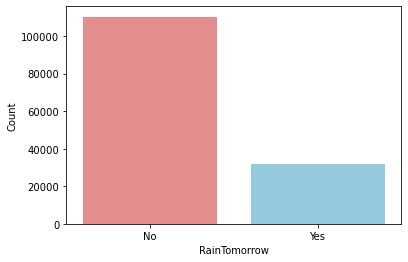

In [5]:
sns.countplot(df["RainTomorrow"],palette=["lightcoral","skyblue"])
plt.ylabel("Count")

In [6]:
df["RainTomorrow"]=df["RainTomorrow"].apply(lambda x:0 if x=="No" else 1)

Now let's go through and check the values for each feature. We will start with the numerical features:

In [7]:
df.describe().drop(["RainTomorrow"],axis=1).T

,count,mean,std,min,25%,50%,75%,max
MinTemp,143975.0,12.194034,6.398495,-8.5,7.6,12.0,16.9,33.9
MaxTemp,144199.0,23.221348,7.119049,-4.8,17.9,22.6,28.2,48.1
Rainfall,142199.0,2.360918,8.478060,0.0,0.0,0.0,0.8,371.0
Evaporation,82670.0,5.468232,4.193704,0.0,2.6,4.8,7.4,145.0
Sunshine,75625.0,7.611178,3.785483,0.0,4.8,8.4,10.6,14.5
WindGustSpeed,135197.0,40.035230,13.607062,6.0,31.0,39.0,48.0,135.0
WindSpeed9am,143693.0,14.043426,8.915375,0.0,7.0,13.0,19.0,130.0
WindSpeed3pm,142398.0,18.662657,8.809800,0.0,13.0,19.0,24.0,87.0
Humidity9am,142806.0,68.880831,19.029164,0.0,57.0,70.0,83.0,100.0
Humidity3pm,140953.0,51.539116,20.795902,0.0,37.0,52.0,66.0,100.0


In [8]:
for column in df.select_dtypes(exclude="object").drop(["RainTomorrow"],axis=1).columns:
    print(column,":",df[column].isnull().sum(),"missing values.")

MinTemp : 1485 missing values.
MaxTemp : 1261 missing values.
Rainfall : 3261 missing values.
Evaporation : 62790 missing values.
Sunshine : 69835 missing values.
WindGustSpeed : 10263 missing values.
WindSpeed9am : 1767 missing values.
WindSpeed3pm : 3062 missing values.
Humidity9am : 2654 missing values.
Humidity3pm : 4507 missing values.
Pressure9am : 15065 missing values.
Pressure3pm : 15028 missing values.
Cloud9am : 55888 missing values.
Cloud3pm : 59358 missing values.
Temp9am : 1767 missing values.
Temp3pm : 3609 missing values.


Quite a number of missing values, which we will impute after we split the data.

For numerical features, it is important to remove any outliers to improve model's performance.

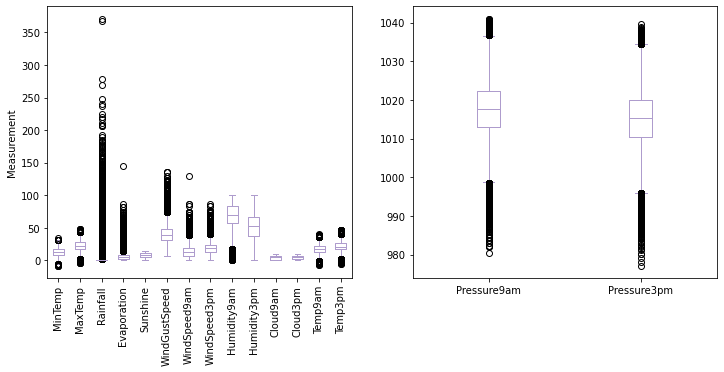

In [9]:
fig,axes=plt.subplots(1,2,figsize=(12,5))

df[df.select_dtypes(exclude="object").columns.drop(["Pressure9am","Pressure3pm","RainTomorrow"])].plot(kind="box",color="#AE9CCD",ax=axes[0])
axes[0].set_xticklabels(axes[0].get_xticklabels(),rotation=90)
axes[0].set_ylabel("Measurement")

df[["Pressure9am","Pressure3pm"]].plot(kind="box",color="#AE9CCD",ax=axes[1])

From the above boxplots, we have quite a number of outliers outside 1.5 times the interquartile range. But because there are no real bounds for weather data, i.e. due to extreme weather events, we will not be removing all of these outliers. If we do we will be creating a perfect dataset that won't properly reflect real world weather. Instead let's just further examine the outliers of the outliers in *Rainfall*, *Evaporation* and *WindSpeed9am*:

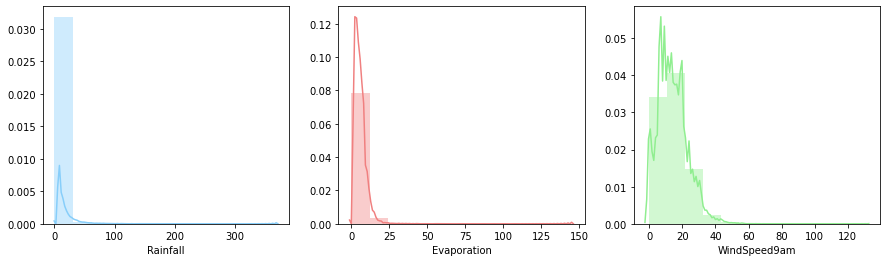

In [10]:
fig,axes=plt.subplots(1,3,figsize=(15,4))

sns.distplot(df["Rainfall"],bins=12,color="lightskyblue",ax=axes[0])
sns.distplot(df["Evaporation"],bins=12,color="lightcoral",ax=axes[1])
sns.distplot(df["WindSpeed9am"],bins=12,color="lightgreen",ax=axes[2])

Although it is possible to achieve these amounts of rainfall, evaporation and wind speed - for example in a storm or heatwave event - we remove them from the dataset so the model doesn't think these extreme weather events are common.